In [6]:
import numpy as np
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib notebook

mpl.rcParams['axes.spines.top'] = 0
mpl.rcParams['axes.spines.right'] = 0
mpl.rcParams['axes.spines.left'] = 1
mpl.rcParams['axes.spines.bottom'] = 1
mpl.rcParams.update({'font.size': 12})

# Lecture 4: Likelihood Ratios and Linear Regression
## Pattern Recognition, Fall 2022

**Ivan Dokmanić**


<img src="figs/sada-unibas-0.svg" width="60%" float="left">


# Updates

- First graded homework assignment coming out today
- An easy one to warm up!

# Recap

# Recap: Types of errors (and successes)

**<center>Confusion table</center>**

|                   | $Y = 0$        | $Y = 1$        |
|-------------------|----------------|----------------|
| $\widehat{Y} = 0$ | true negative  | false negative |
| $\widehat{Y} = 1$ | false positive | true positive  |

1. **True positive rate**: $\mathrm{TPR} = \mathbb{P}[\hat{Y}(X) = 1 \mid Y=1]$. A.k.a. _power_, _sensitivity_, _probability of detection_, _recall_
2. **False negative rate**: $\mathrm{FNR} = 1 - \mathrm{TPR}$: A.k.a. _type-II error_, _probability of missed detection_
3. **False positive rate**: $\mathrm{FPR} = \mathbb{P}[Y(X) = 1 \mid Y=0]$: A.k.a. _size_ or _type I error_ or _probability of false alarm_
4. **True negative rate**: $\mathrm{TNR} = 1 - \mathrm{FPR}$: A.k.a. _specificity_

In [4]:
# let's do a bit more Gaussian stuff before moving on to ROC (stop here and make a video for the rest)

sig1 = 1
sig2 = 3
loc1 = 0.0
loc2 = 4
p1 = 0.3
p2 = 1 - p1

<IPython.core.display.Javascript object>


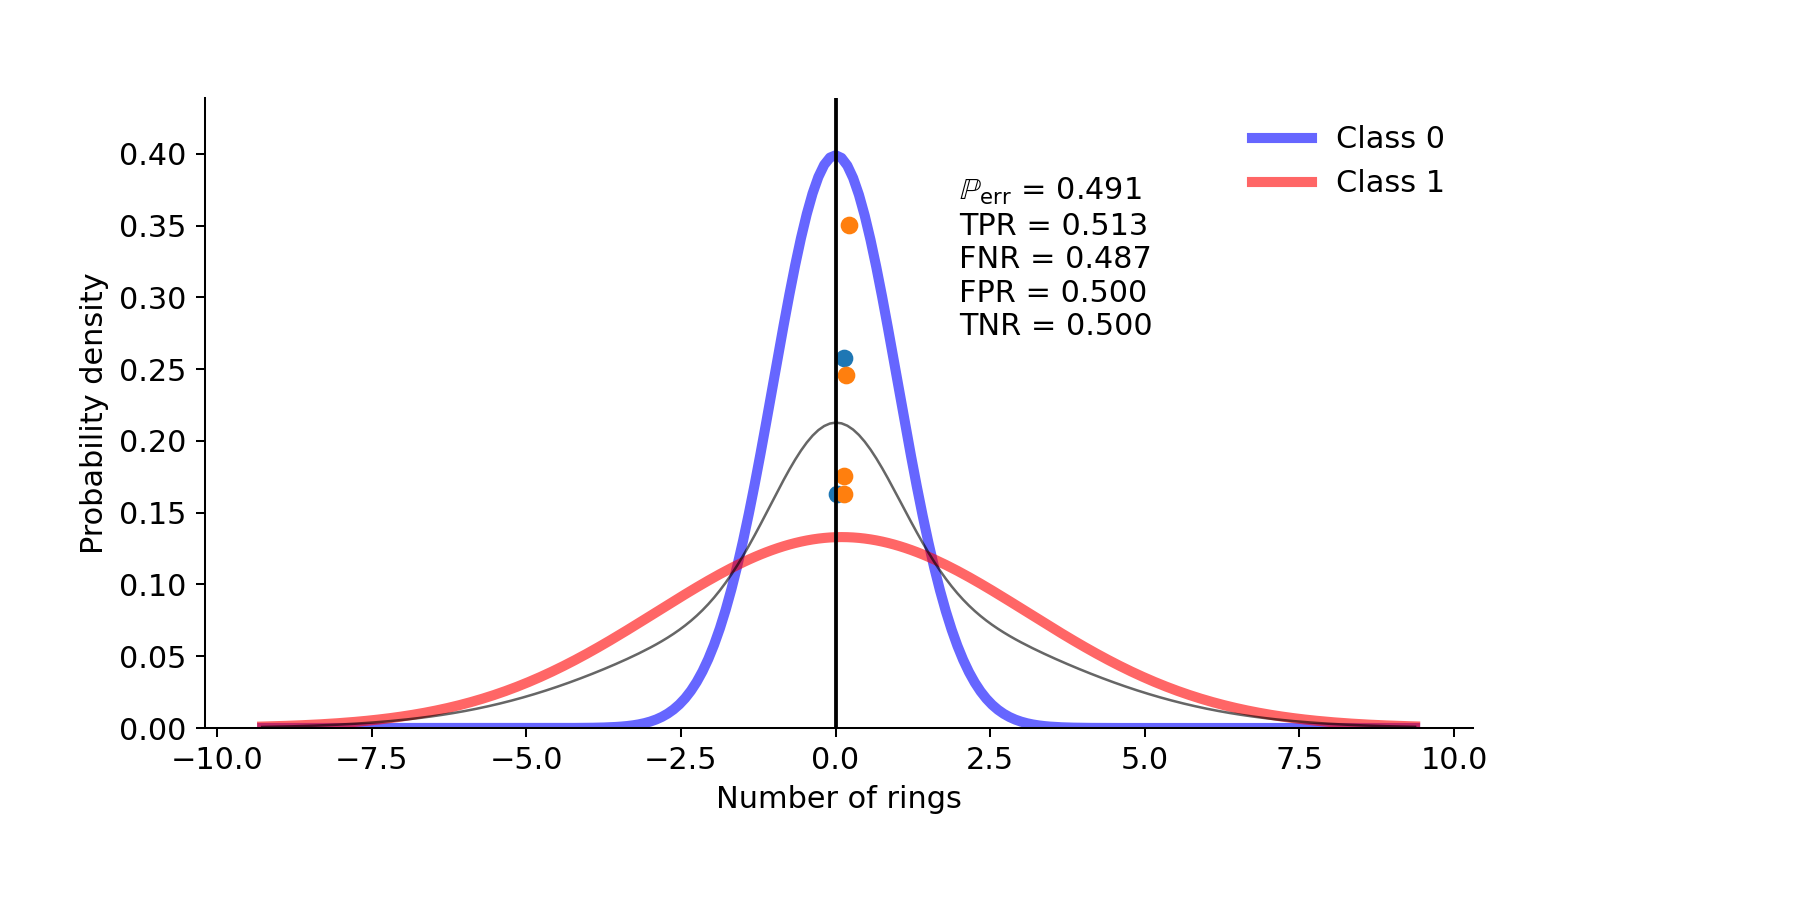

interactive(children=(FloatSlider(value=0.0, description='thr', max=9.37069691850344, min=-9.27069691850344, s…

In [22]:
from scipy.stats import norm

x_min = norm.ppf(0.001, loc=min(loc1, loc2), scale=max(sig1, sig2))
x_max = norm.ppf(0.999, loc=max(loc1, loc2), scale=max(sig1, sig2))                
x = np.linspace(x_min, x_max, 200)

fig, ax = plt.subplots(1, 1, figsize=(9, 4.5))
line1, = ax.plot(x, norm.pdf(x, loc=loc1, scale=sig1),
       'b-', lw=4, alpha=0.6)
line2, = ax.plot(x, norm.pdf(x, loc=loc2, scale=sig2),
       'r-', lw=4, alpha=0.6)
line3, = ax.plot(x, p1*norm.pdf(x, loc=loc1, scale=sig1) + p2*norm.pdf(x, loc=loc2, scale=sig2),
       'k-', lw=1, alpha=0.6)

text_str = '$\mathbb{P}_{\mathrm{err}}$ = %0.3f\n' \
         + 'TPR = %0.3f\n' \
         + 'FNR = %0.3f\n' \
         + 'FPR = %0.3f\n' \
         + 'TNR = %0.3f\n'

text = ax.text(2, 0.25, text_str % (0,0,0,0,0))

ax.set_xlabel('Number of rings')
ax.set_ylabel('Probability density')
ax.legend(['Class 0', 'Class 1'], frameon=False)
y_max = 1.1 / min(sig1, sig2) / np.sqrt(2 * np.pi)
ax.set_ylim(0, y_max)

thr0 = 0
thrline, = ax.plot([thr0, thr0], [0, y_max], 'k')

def update(thr=thr0):

    # FPR = P(\hat{Y} = 1 | Y = 0)
    #     = P(BLUE > thr)
    FPR = 1 - norm.cdf(thr, loc=loc1, scale=sig1)
    # FPR = P(\hat{Y} = 0 | Y = 1)
    #     = P(RED <= thr)
    FNR = norm.cdf(thr, loc=loc2, scale=sig2)
    
    # P(mistake) = P(\hat{Y} = 1 | Y = 0) * p_0 + P(\hat{Y} = 0 | Y = 1) * p_1
    #            = p_0 * FPR + p_1 * FNR
    p_mistake = p1*FPR + p2*FNR
    
    thrline.set_xdata([thr, thr])
    text.set_text(text_str % (p_mistake, 1 - FNR, FNR, FPR, 1 - FPR))
    fig.canvas.draw_idle()

interact(update, thr=(x_min, x_max, (x_max - x_min) / 300));

# Quiz

For this one you may need a pencil, a piece paper, and a bit of thinking...

We derived the optimal classifier when likelihoods are Gaussians whose means differ by $s$,
$$
\widehat{Y}=\mathbb{1}\left\{s X > \frac{1}{2} s^2+\log (\eta)\right\}.
$$
This rule splits the real line in two half-infinite intervals $\left(-\infty, \frac{1}{2}s + \frac{1}{s} \log \eta\right)$ and 
$\left(\frac{1}{2}s + \frac{1}{s} \log \eta, \infty\right)$. Now consider the general case of binary classification with Gaussian likelihoods,
$$
\begin{align}
    p(x \,|\, Y = 0) &= \mathcal{N}(\mu_0, \sigma_0^2) = \tfrac{1}{\sigma_0\sqrt{2\pi}} e^{-\frac{(x - \mu_0)^2}{2\sigma_0^2}} \\
    p(x \,|\, Y = 1) &= \mathcal{N}(\mu_1, \sigma_1^2) = \tfrac{1}{\sigma_1\sqrt{2\pi}} e^{-\frac{(x - \mu_1)^2}{2\sigma_1^2}}
\end{align}
$$
Does it hold for any choice of $\mu_0, \sigma_0, \mu_1, \sigma_1$ that the optimal rule splits the real line in two intervals?



# Plan for today

- Continue with types of errors, Neyman–Pearson
- A "statistical" point of view on likelihood ratios (MAP, ML estimation)
- Towards supervised learning
- Begin with linear regression

# FYI

- TPR, FPR, FNR, TNR are defined relative to the class size
- There exist better measures for situations with unbalanced classes
    - Precision
    - F1-score
    - False discovery rate
- Notes coming up but for now we're moving on!

# Receiver operating characteristic (ROC) curves


- Risk minimization = balancing TPR and FPR
- Competing objectives

$$
R[\hat{Y}] := \mathbb{E} [\mathrm{loss}(\hat{Y}(X), Y)] = \alpha \mathrm{FPR} - \beta \mathrm{TPR} + \gamma
$$

- assume nonnegative $\alpha$ and $\beta$. Fact: for all $\alpha$, $\beta$, $\gamma$, the risk-minimizing predictor is an LRT

- The obvious question: can we achieve _**any**_ combination of $\mathrm{FPR}$ and $\mathrm{TPR}$?




The answer is given by the ROC curve

- The ROC curve is an intrinsic property of the joint distribution of $(X, Y)$
- for every $\mathrm{FPR} \in [0, 1]$ it shows the best $\mathrm{TPR}$ achievable by _any_ predictor with that $\mathrm{FPR}$
- the ROC curve contains points $\mathrm{FPR}, \mathrm{TPR} = (0, 0)$ and $\mathrm{FPR}, \mathrm{TPR} = (1, 1)$


We want

$$
\begin{aligned}
    \text{maximize}  ~  &\mathrm{TPR} \\
    \text{subject to} ~ &\mathrm{FPR} \leq \phi
\end{aligned}
$$

**Lemma (Neyman–Pearson).** The optimal predictor that maximizes TPR with an upper bound on FPR is a likelihood ratio test. 

This is super-great: the ROC curve is traced out by varying the threshold in the LRT from $-\infty$ to $+\infty$


# Some properties of ROC curves

- it contains points (0, 0) and (1, 1)
- it lies above the diagonal
- it is concave: for any achievable $\left(\operatorname{FPR}\left(\eta_1\right), \operatorname{TPR}\left(\eta_1\right)\right)$ and $\left(\operatorname{FPR}\left(\eta_2\right), \operatorname{TPR}\left(\eta_2\right)\right)$, the following is also achievable:

$$
\left(t \operatorname{FPR}\left(\eta_1\right)+(1-t) \operatorname{FPR}\left(\eta_2\right), t \operatorname{TPR}\left(\eta_1\right)+(1-t) \operatorname{TPR}\left(\eta_2\right)\right)
$$

In [104]:
sigma = 1
loc1 = 0.0
loc2 = 10

<IPython.core.display.Javascript object>


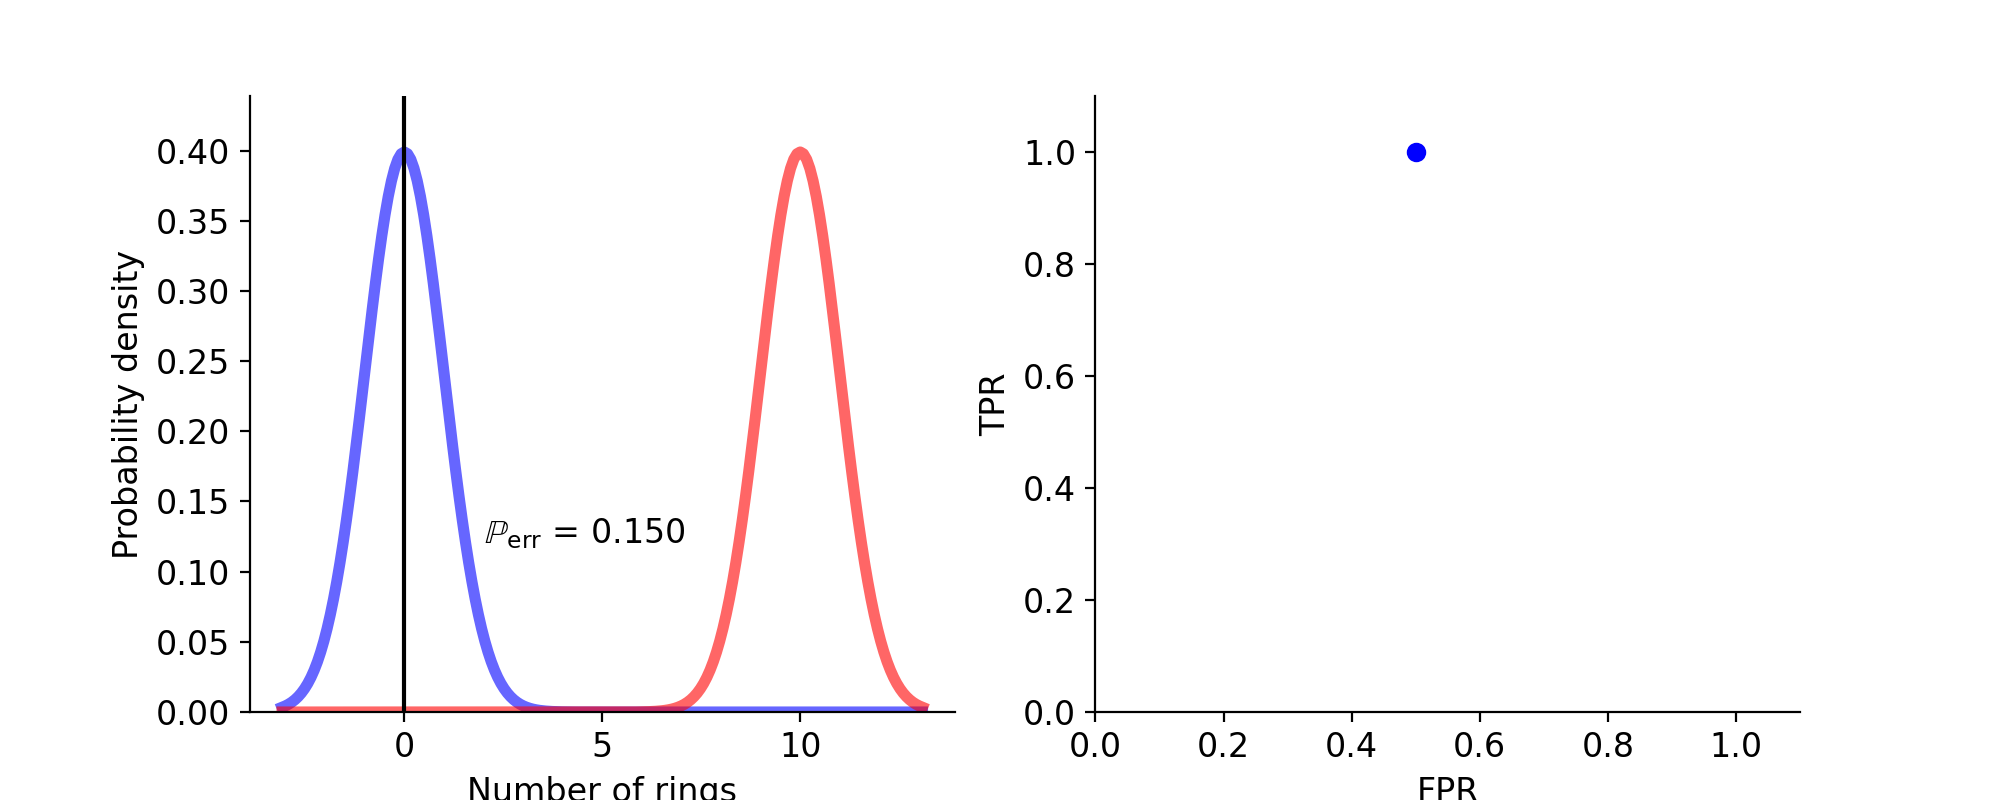

interactive(children=(FloatSlider(value=0.0, description='thr', max=13.090232306167813, min=-3.090232306167813…

In [105]:
from scipy.stats import norm

x_min = norm.ppf(0.001, loc=min(loc1, loc2), scale=sigma)
x_max = norm.ppf(0.999, loc=max(loc1, loc2), scale=sigma)
x = np.linspace(x_min, x_max, 200)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
ax = axs[0]
line1, = ax.plot(x, norm.pdf(x, loc=loc1, scale=sigma),
       'b-', lw=4, alpha=0.6, label='skewnorm pdf')
line2, = ax.plot(x, norm.pdf(x, loc=loc2, scale=sigma),
       'r-', lw=4, alpha=0.6, label='skewnorm pdf')
text = ax.text(2, 0.12, '$\mathbb{P}_{\mathrm{err}}$ = %0.3f' % (0,))

ax.set_xlabel('Number of rings')
ax.set_ylabel('Probability density')
y_max = 1.1 / sigma / np.sqrt(2 * np.pi)
ax.set_ylim(0, y_max)
axs[1].set_xlim(0, 1.1)
axs[1].set_ylim(0, 1.1)
axs[1].set_xlabel("FPR")
axs[1].set_ylabel("TPR")

thr0 = 0
thrline, = ax.plot([thr0, thr0], [0, y_max], 'k')

def update(thr=thr0):
    FPR = 1 - norm.cdf(thr, loc=loc1, scale=sigma)
    FNR = norm.cdf(thr, loc=loc2, scale=sigma)
    TPR = 1 - FNR    
    
    p_mistake = p1*FPR + p2*FNR
    thrline.set_xdata([thr, thr])
    text.set_text('$\mathbb{P}_{\mathrm{err}}$ = %0.3f' % (p_mistake,))

    axs[1].scatter(FPR, TPR, color='b')
    
    fig.canvas.draw_idle()
    
interact(update, thr=(x_min, x_max, (x_max - x_min) / 200));

# interpret these results for the students

# End of first hour

# Maximum a posteriori and maximum likelihood

- "Folk theorem" in decision theory: all optimal rules are equivalent to likelihood tests
    - not 100% true but pretty close
- (Famous) "workhorse" statistical predictors (we will see them often): MAP, ML _**are**_ LRTs

- Expected error of a predictor = expected number of mistakes = risk with the loss

| loss | $\hat{Y}$ = 0 | $\hat{Y}$ = 1|
|-----|--------:|--------:|
| $Y$ = 0 | 0   |  1  |
| $Y$ = 1 | 1 | 0  |


- We know that risk minimizers are given by likelihood ratio tests! Here we have

$$
 \frac{p_0(\operatorname{loss}(1,0)-\operatorname{loss}(0,0))}{p_1(\operatorname{loss}(0,1)-\operatorname{loss}(1,1))} = \frac{p_0}{p_1} \cdot \frac{1 - 0}{1 - 0} = \frac{p_0}{p_1}
$$



$$
\begin{aligned}
\hat{Y}(x) 
&= \mathbb{1} \left\{ \mathcal{L}(x) \geq \frac{p_0}{p_1} \right\} \\
&= \mathbb{1} \left\{  \frac{p(x \mid y = 1)}{p(x \mid y = 0)} \geq \frac{p_0}{p_1} \right\} \\
&= \mathbb{1} \bigg\{  p_1 p(x \mid y = 1) \geq p_0 p(x \mid y = 0) \bigg\} \\
&= \mathbb{1} \bigg\{  \mathbb{P}[Y = 1 \mid X = x] \geq \mathbb{P}[Y = 0 \mid X = x] \bigg\} \\
&= \arg\max_{y \in \{ 0, 1\}} \mathbb{P}[Y = y \mid X = x]
\end{aligned}
$$


# ML

$$
    \hat{Y}_\text{ML}(x) = \arg\max_y p(x | Y = y)
$$

Equivalent to MAP (and hence a likelihood ratio test) when $p_0 = p_1$

# Part 2: towards supervised learning

# Setting

So far we were constructing optimal (risk-minimizing) prediction rules of the form

$$
    \hat{Y}(x) = \mathbb{1}(\mathcal{L}(x) \geq \eta)
$$

but in reality we rarely know the likelihoods (or the joint distribution) needed to compute $\mathcal{L}(x)$. Likelihoods characterize the pair of random variables $(X, Y)$ which model a _**population**_ of instances (patterns). Two questions loom:

1. What knowledge can we assume to have?
2. How to build algorithms given this knowledge?

# Sample vs population

- In supervised learning we assume having access to $n$ ``labeled'' patterns (or instances)

$$
    (x_1, y_1), (x_2, y_2), \ldots, (x_n, y_n)
$$

- we assume that each pattern–label pair $(x_i, y_i)$ is a _draw_ from the same distribution as that of $(X, Y)$ (sometimes you'll hear the word _realization_)
- both _draw_ and _realization_ are a bit imprecise but convenient; deterministic numbers admit no notion of distribution or independence
- when we want to do math and statistics of learning, we assume that the sample consists of $n$ iid copies of $(X, Y)$ 

$$
    (X_1, Y_1), (X_2, Y_2), \ldots, (X_n, Y_n)
$$

- by copies we mean variables with the same joint distribution but independent for different $i$
- key assumption of ``independent, identically-distributed random variables'' (iid, i.i.d.)

# Part 3: Linear models

- linear functions of data

## Linear regression

We have i.i.d. samples

<IPython.core.display.Javascript object>


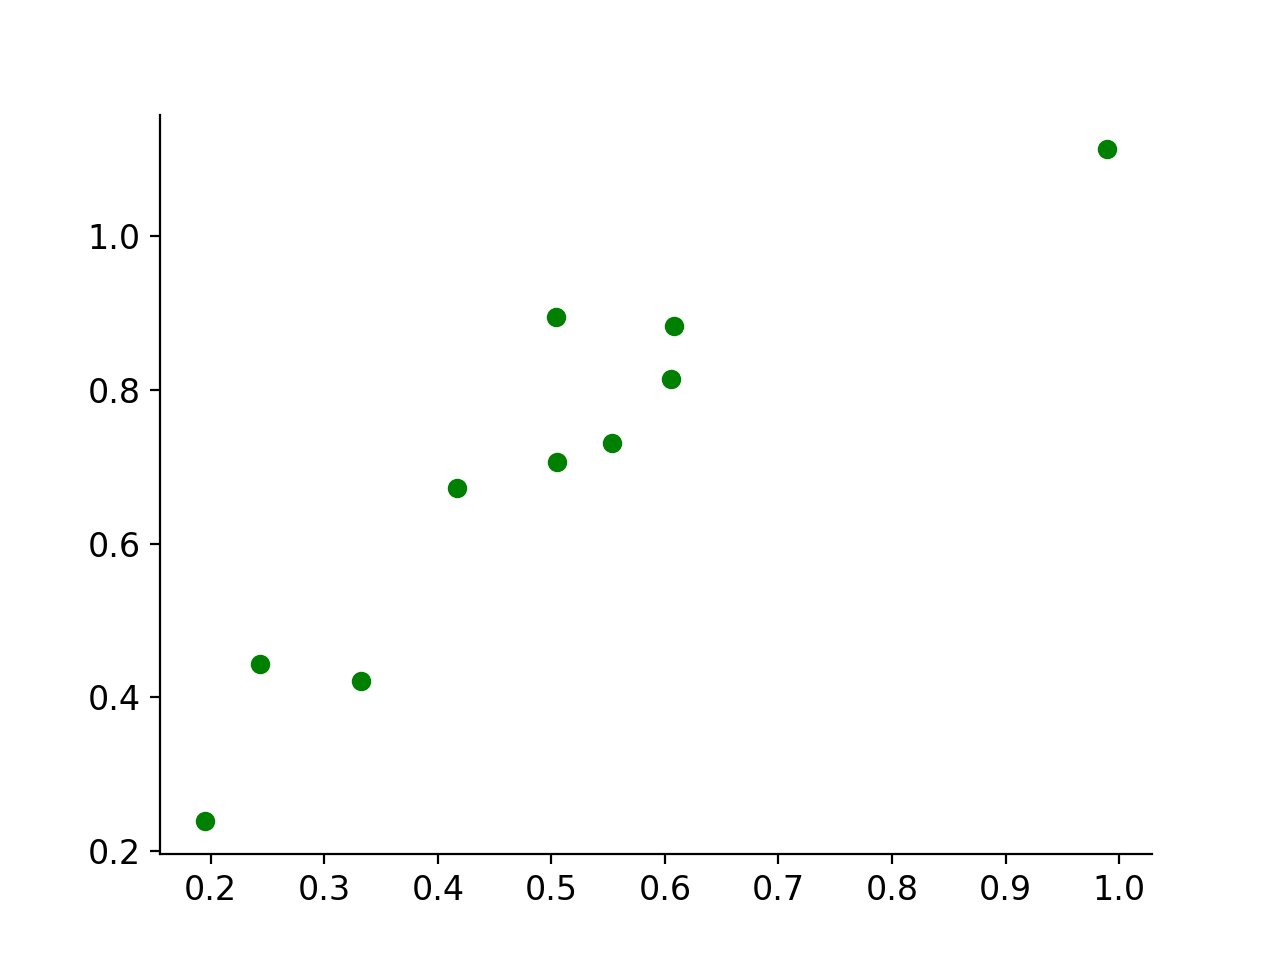

interactive(children=(IntSlider(value=0, description='method', max=3), Output()), _dom_classes=('widget-intera…

In [108]:
from sklearn.linear_model import LinearRegression

n = 10
a = 1.0
b = 0.2
sig = 0.08
deg = n - 1

x = np.random.rand(n, 1)
x = np.sort(x, axis=0)
y = a*x + b + sig*np.random.randn(n, 1)

fig, ax = plt.subplots(1, 1)
ax.scatter(x, y, color='g')

reg = LinearRegression().fit(x, y)
p = np.poly1d(np.polyfit(x.flatten(), y.flatten(), deg))

x_grid = np.linspace(0, 1, 200).reshape(-1, 1)

line, = ax.plot([],[], 'k')

def update(method=0):
    if method == 0:
        line.set_xdata([])
        line.set_ydata([])
    elif method == 1:
        line.set_xdata(x_grid)
        line.set_ydata(reg.predict(x_grid))
    elif method == 2:
        line.set_xdata(x)
        line.set_ydata(y)
    elif method == 3:
        line.set_xdata(x_grid)
        line.set_ydata(p(x_grid))

    fig.canvas.draw_idle()
    
interact(update, method=(0, 3));

# Linear regression

We assume a linear model

$$
\hat{Y}(x) = \hat{y} = w_0 + w_1 \cdot x
$$

- Which $w_0$, $w_1$ should we take? Those that minimize the error!
- How do we measure error for 1 sample? Typically for linear regression, quadratic error,
$$
    \mathrm{loss}(\hat{y}, y) = (\hat{y} - y)^2
$$
- Earlier we would have tried something like $\min_{w_0, w_1} \mathbb{E} ~ \mathrm{loss}(\hat{Y}(X), Y) = \min_{w_0, w_1} \mathbb{E} ~ (w_0 + w_1 X - Y)^2$ but now we are in the realistic supervised learning mode so we cannot compute expectations
- We then attempt to solve
$$
    \min_{w_0, w_1} \frac{1}{n} \sum_{i = 1}^n (w_0 + w_1 x_i - y_i)^2
$$

<IPython.core.display.Javascript object>


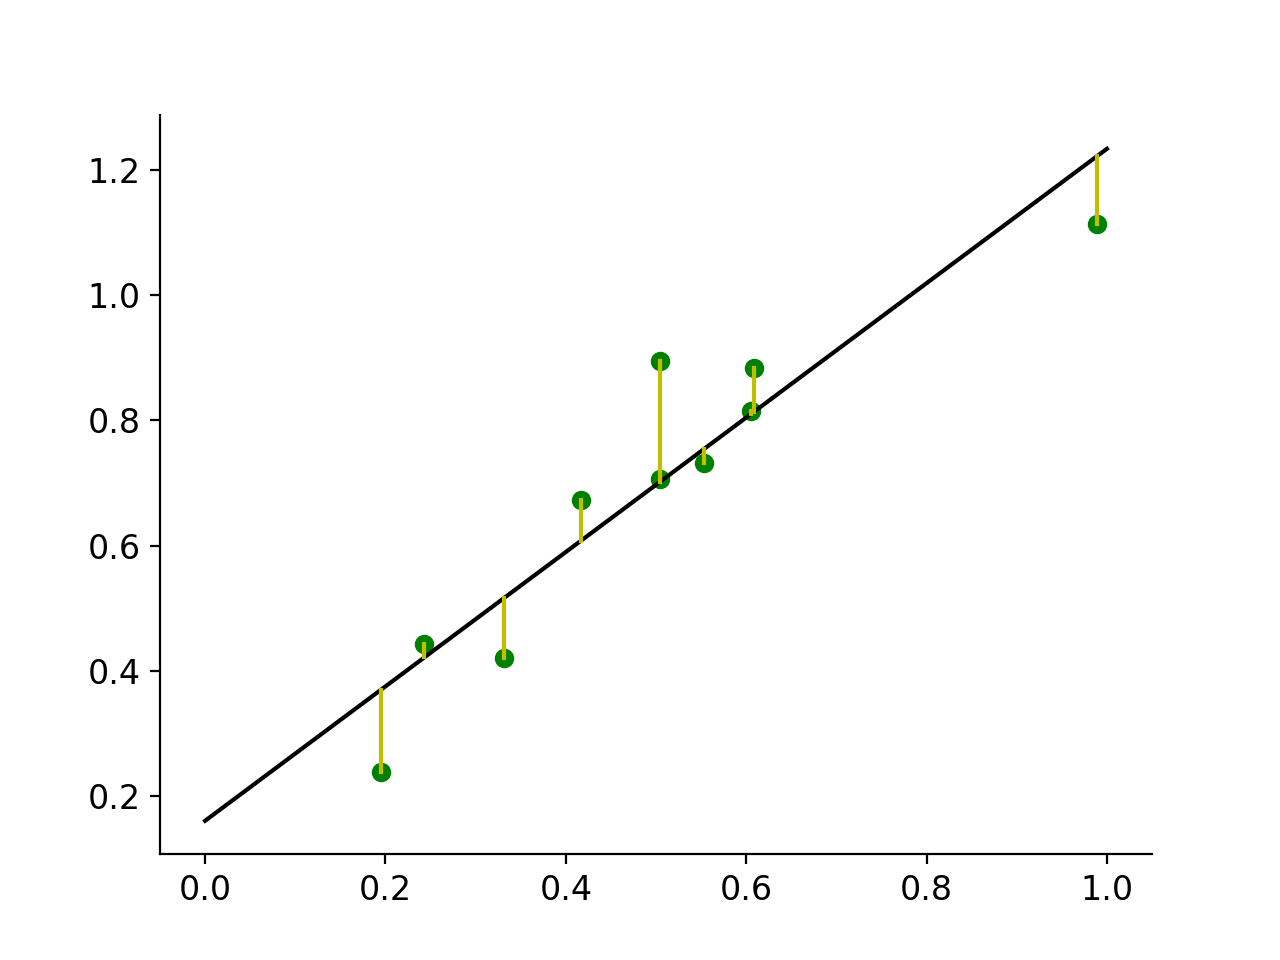

In [109]:
fig, ax = plt.subplots(1, 1)
ax.scatter(x, y, color='g')

reg = LinearRegression().fit(x, y)
y_hat = reg.predict(x)

x_grid = np.linspace(0, 1, 200).reshape(-1, 1)
line, = ax.plot(x_grid, reg.predict(x_grid), 'k')
for i in range(n):
    plt.plot([x[i], x[i]], [y[i], y_hat[i]], 'y')


How to find $w_0$ and $w_1$? Take derivatives and set to zero... (the convenient $\frac{1}{2}$ does not change optimal $w_0$, $w_1$)

$$
\begin{aligned}
    \frac{\partial}{\partial w_0} \left\{ \frac{1}{2n} \sum_{i = 1}^n (w_0 + w_1 x_i - y_i)^2 \right\}
    &=
    \frac{1}{n} \sum_{i = 1}^n (w_0 + w_1 x_i - y_i) = w_0 + w_1 \frac{1}{n} \sum_{i=1}^n x_i - \frac{1}{n} \sum_{i=1}^n y_i \\
    &=: w_0 + w_1 \overline{x} - \overline{y} \\
    \frac{\partial}{\partial w_1} \left\{ \frac{1}{2n} \sum_{i = 1}^n (w_0 + w_1 x_i - y_i)^2 \right\}
    &=
    \frac{1}{n} \sum_{i = 1}^n (w_0 + w_1 x_i - y_i) x_i = w_0 \frac{1}{n} \sum_{i=1}^n x_i + w_1 \frac{1}{n} \sum_{i=1}^n x_i^2 - \frac{1}{n} \sum_{i=1}^n y_i x_i \\
    &=: w_0 \overline x + w_1 \overline {x^2} - \overline{x y}
\end{aligned}
$$


$\newcommand{\emp}{\hat{\mathbb{E}}}$

$$
\bar{x} \bar{y} - w_1 \bar{x}^2 + w_1 \bar{x^2} - \overline{xy} = 0
$$

$$
w_1 (\bar{x^2} - \bar{x}^2) = \bar{xy} - \bar{x}\bar{y}
$$

$$
    w_1 = \frac{\emp[xy] - \emp[x]\emp[y]}{\emp[x^2] - \emp[x]^2} \quad \quad w_0 = \emp[y] - w_1 \emp[x]
$$

Towards a more general formulation

$$
(w_0 + w_1 x - y)^2 = \left([1 \quad x] \begin{bmatrix}w_0 \\ w_1\end{bmatrix} - y\right)^2
$$


(separate out intercept to compare with previous slide)



$$
\arg \min_{w_0, w_1} \frac{1}{2}
\left\|
\left[\begin{array}{c}
y_1 \\
\vdots \\
y_n
\end{array}\right]
-
\left[\begin{array}{cc}
1 & x_1 \\
\vdots & \vdots \\
1 & x_n
\end{array}\right] 
\left[\begin{array}{l}
w_0 \\
w_1
\end{array}\right]
\right\|_2^2
$$

Denoting
$$
\mathbf{y} = \left[\begin{array}{c}
y_1 \\
\vdots \\
y_n
\end{array}\right]
\quad
\mathbf{X} = 
\left[\begin{array}{cc}
1 & x_1 \\
\vdots & \vdots \\
1 & x_n
\end{array}\right]
\quad
\mathbf{w} = \left[\begin{array}{l}
w_0 \\
w_1
\end{array}\right]
$$
we have the following _**loss function**_
$$
\arg \min_{\mathbf{w} \in \mathbb{R}^2} \frac{1}{2} \| \mathbf{y} - \mathbf{X} \mathbf{w} \|^2
$$

(You will need more notation for random vectors)



Solution? Set
$$
\begin{eqnarray}
    \frac{\partial}{\partial w_0} \frac{1}{2} \sum_i (w_0 + w_1 x_i - y_i)^2 &=& n w_0 + w_1 \sum_i x_i - \sum_i y_i 
    &=& 
    [1, \ldots, 1] 
    \left[\begin{array}{cc}
    1 & x_1 \\
    \vdots & \vdots \\
    1 & x_n
    \end{array}\right]
    \begin{bmatrix} w_0 \\ w_1 \end{bmatrix} -  [1, \ldots, 1] \begin{bmatrix}y_1\\ \vdots \\ y_n \end{bmatrix} \\
    \frac{\partial}{\partial w_1} \frac{1}{2} \sum_i (w_0 + w_1 x_i - y_i)^2 
    &=& 
    w_0 \sum_i x_i + w_1 \sum_i x_i^2 - \sum_i x_i y_i 
    &=& 
    [x_1, x_2, \ldots, x_n]
    \left[\begin{array}{cc}
    1 & x_1 \\
    \vdots & \vdots \\
    1 & x_n
    \end{array}\right]
    \begin{bmatrix} w_0 \\ w_1 \end{bmatrix} - [x_1, x_2, \ldots, x_n] \begin{bmatrix}y_1\\ \vdots \\ y_n \end{bmatrix} 
\end{eqnarray}
$$
so 
$$
\begin{aligned}
    \begin{bmatrix}
    \frac{\partial}{\partial w_0} \\
    \frac{\partial}{\partial w_1}
    \end{bmatrix}
    &=
    \begin{bmatrix}
    1 & 1 & \cdots & 1 \\
    x_1 & x_2 & \cdots & x_n
    \end{bmatrix}
    \begin{bmatrix}
    1 & x_1 \\
    1 & x_2 \\
    \vdots & \vdots \\
    1 & x_n
    \end{bmatrix}
    \begin{bmatrix}
    w_0 \\ w_1
    \end{bmatrix}
    -
    \begin{bmatrix}
    1 & 1 & \cdots & 1 \\
    x_1 & x_2 & \cdots & x_n
    \end{bmatrix}
    \begin{bmatrix}
    y_1 \\ y_2 \\ \vdots \\ y_n
    \end{bmatrix}
    \\
    &= \mathbf{X}^T \mathbf{X} \mathbf{w} - \mathbf{X}^T \mathbf{y}
\end{aligned}
$$

Coincidence? I think not.

# Optimal weights

$$
\mathbf{w}^\star = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}
$$

# Higher dimension

- In ``real'' pattern recognition we more or less never have simple scalar patterns / features $x_i \in \mathbb{R}$
- In digit classification we had vector features $\mathbf{x} \in \mathbb{R}^{784}$ or $\mathbf{x} \in \mathbb{R}^{28 \times 28}$
- The prediction is
$$
    \hat{Y}(x) = w_0 + \sum_{i = 1}^d w_i x_i
    =
    [1, x_1, \ldots, x_d]
    \begin{bmatrix}
        w_0 \\ w_1 \\ \vdots \\ w_d
    \end{bmatrix}
    =: \mathbf{x}^T \mathbf{w}
$$

For a training set $(\mathbf{x}_1, y_1), \ldots, (\mathbf{x}_n, y_n)$ we can write
$$
    \mathbf{X} =
    \begin{bmatrix}
        - & \mathbf{x}_1^T & - \\
        - & \vdots & - \\
        - & \mathbf{x}_n^T & -
    \end{bmatrix}
$$
and the loss becomes
$$
\arg \min_{\mathbf{w} \in \mathbb{R}^2} \frac{1}{2} \| \mathbf{y} - \mathbf{X} \mathbf{w} \|^2
$$
which is suspiciously similar to what we had before!

<IPython.core.display.Javascript object>


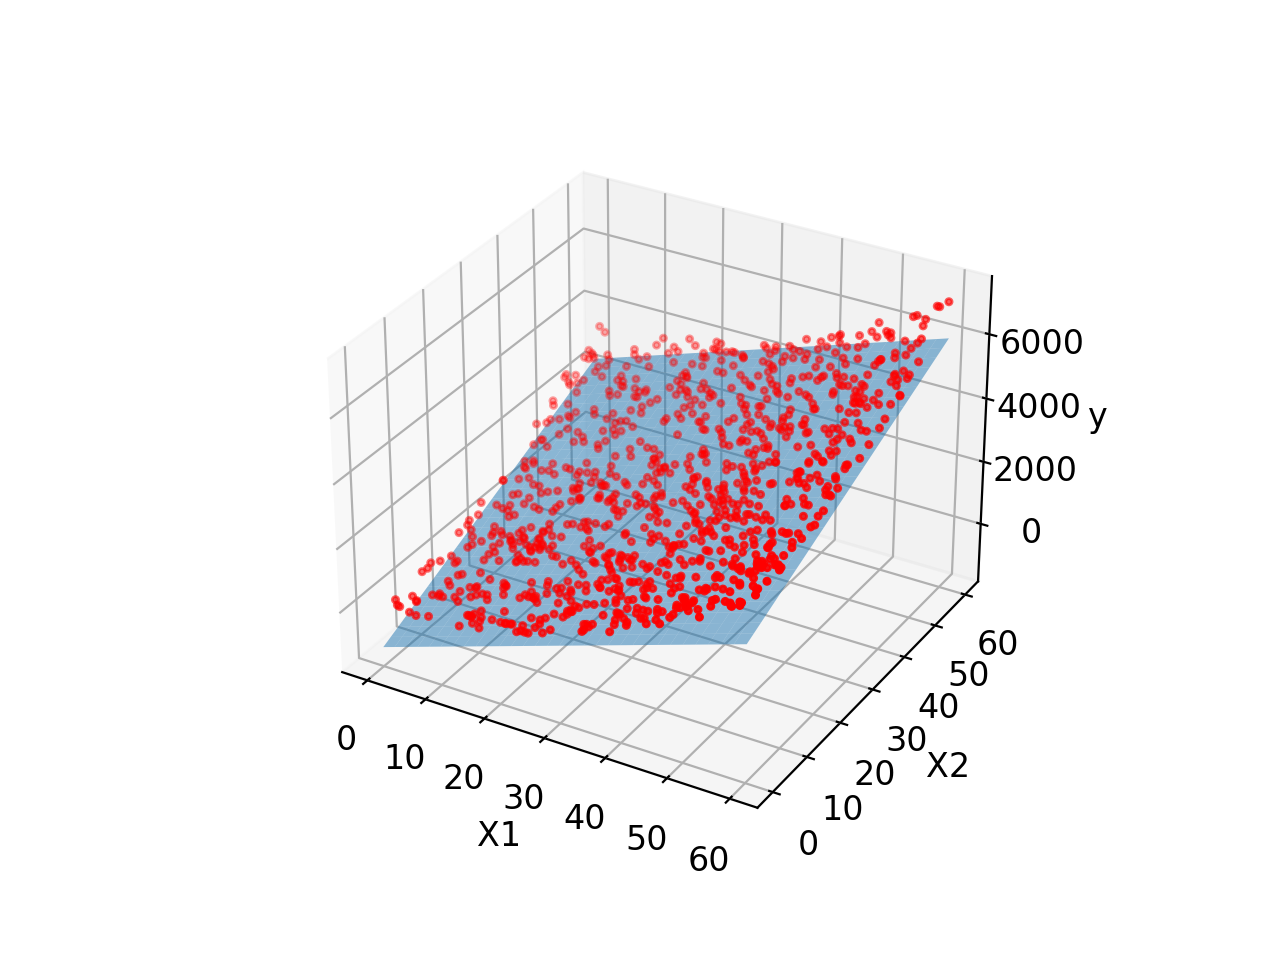

MAE: 300.8159248227424
RMSE: 366.05226732122185
Equation: y = -1271.75 + 61.07x1 + 60.69x2


In [106]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn.linear_model

from mpl_toolkits.mplot3d import Axes3D

X_train = np.random.rand(2000).reshape(1000,2)*60
y_train = (X_train[:, 0]**2)+(X_train[:, 1]**2)
X_test = np.random.rand(200).reshape(100,2)*60
y_test = (X_test[:, 0]**2)+(X_test[:, 1]**2)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train[:,0], X_train[:,1], y_train, marker='.', color='red')
ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_zlabel("y")

model = sklearn.linear_model.LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("MAE: {}".format(np.abs(y_test-y_pred).mean()))
print("RMSE: {}".format(np.sqrt(((y_test-y_pred)**2).mean())))

coefs = model.coef_
intercept = model.intercept_
xs = np.tile(np.arange(61), (61,1))
ys = np.tile(np.arange(61), (61,1)).T
zs = xs*coefs[0]+ys*coefs[1]+intercept
print("Equation: y = {:.2f} + {:.2f}x1 + {:.2f}x2".format(intercept, coefs[0],
                                                          coefs[1]))

ax.plot_surface(xs,ys,zs, alpha=0.5)
plt.show()